# Asennusmäärän ennustaminen

Käytetään koneoppimismalleja aurinkopaneelien asennusmäärän ennustamiseen aikasarjalla. Aluksi luodaan aikasarja, jossa on oletuksena kuukausittaiset asennusmäärät, jotka voidaan korvata myös viikoittaisilla määrillä.

Ennusteen tekemistä varten määritetään mallin syötteen ja ennusteen pituus aika-askelina. Ennuste tehdään syötettä seuraaville aika-askelille. Ennusteen pituus vaikuttaa myös opetusaineiston pituuteen, sillä yhtään ennustettavaa arvoa ei haluta sisällyttää opetusaineiston aikasarjoihin.

Käytettävä data on mahdollista rajoittaa halutulle aikavälille. Ennuste tehdään aina valitun aikavälin loppupäähän. Alkupään datapisteitä käytetään opetusaineistona.

## Kirjastot

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from datetime import datetime

import importlib.util
import sys
file_path = "../../Tehtava-03/preprocessor.py"; module_name = "preprocessor"; spec = importlib.util.spec_from_file_location(module_name, file_path)
esik = importlib.util.module_from_spec(spec); sys.modules[module_name] = esik; spec.loader.exec_module(esik)

## Esikäsittelijän ajaminen

In [2]:
customer_segment = 'customer_segment'
cols = ['installation_date', customer_segment]
df_all = esik.esik(cols)


## Esikäsittely jatkuu

### Luodaan aikasarja

Aikasarjan indeksinä on oletuksena kuukausi ja arvona kaikkien kyseisen kuukauden aikana tehtyjen asennusten määrä valitussa asiakassegmentissä. Merkitään myös nollat.

In [3]:
df = df_all.copy()
# Valitaan tarkasteltava asiakasryhmä
df = df[df[customer_segment] == 'RES']
df.drop([customer_segment], axis=1, inplace=True)

# Aika-askel
freq = 'M'  # Voi olla myös 'W'
time_format = '%Y-%m'  # Vaihdetaan '%Y-%W', jos käsitellään viikottaista asennusmäärää

# Lasketaan asennukset
df['time_step'] = df['installation_date'].dt.strftime(time_format)
df = df['time_step'].value_counts().sort_index()
df = pd.DataFrame({'time_step': df.index, 'count': df})

# Tavoiteltava indeksi
index_period = pd.period_range(start='1998-01-01', end='2019-12-29', freq=freq).strftime(time_format)
period = pd.DataFrame(data=index_period, columns=['time_step'], dtype='object')
index_period = pd.period_range(start='1998-01-01', end='2019-12-29', freq=freq)

# Yhdistetään ja lisätään nollat
df_time_serie = period.merge(df, how='left', on='time_step')
df_time_serie.fillna(0, inplace=True)
df_time_serie.index = index_period
df_time_serie.drop(['time_step'], axis=1, inplace=True)
display(df_time_serie)


,count
1998-01,1.0
1998-02,1.0
1998-03,0.0
1998-04,1.0
1998-05,2.0
...,...
2019-08,13571.0
2019-09,13073.0
2019-10,13019.0
2019-11,13405.0


### Muokataan ja valitaan data mallia varten

Tässä vaiheessa valitaan data määrittämällä aikaväli. Valinta määrää käytännössä opetusaineiston alkupisteen ja ennusteen loppupisteen.

Samalla valitaan mallin käyttämän syötteen ja tehtävän ennusteen pituus, joka määritetään aika-askelina.

Edellisten valintojen tekemisen jälkeen piirretään asennusmäärien kuvaaja. Tarkkojen määrien ohella kuvaan piirretään myös eksponentiaalisesti painotettu keskiarvo sekä liukuva keskiarvo. Niiden avulla asennusmäärien arvojen vaihtelu tasautuu jonkin verran peräkkäisten aika-askelten välillä, mikä todennäköisesti parantaa trendin ennustettavuutta.

Piirtämisen jälkeen tehdään valinta mitä käyrää käytetään mallin datana.

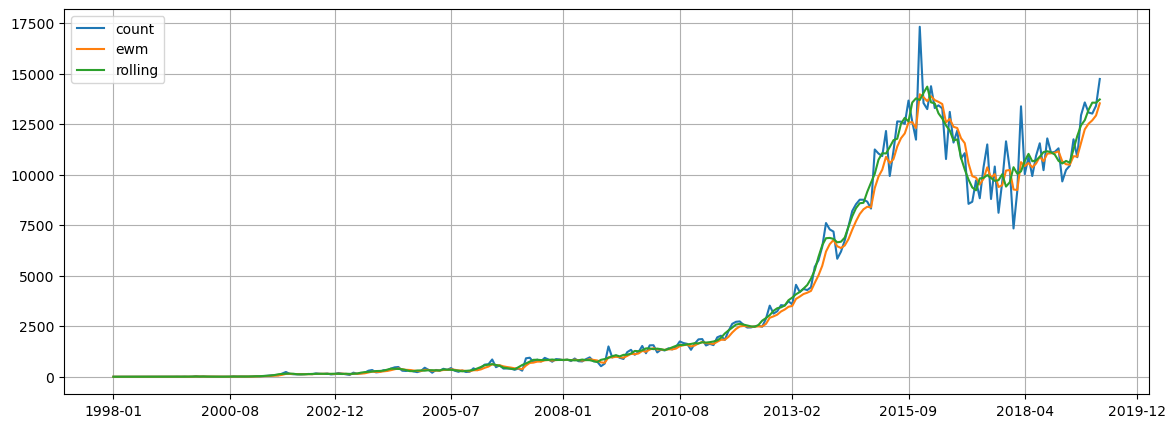

In [4]:
start = '1998-01-01'
end = '2019-12-29'

input_len = 6
output_len = 6

# Vertailuarvot
df = df_time_serie.copy()
df['ewm_count'] = df['count'].ewm(com=2).mean()
df['rolling_count'] = df['count'].rolling(5, min_periods=3, center=True).mean()

# Rajaus
a = datetime.fromisoformat(start).strftime(time_format)
b = datetime.fromisoformat(end).strftime(time_format)
df = df.loc[a:b,:]

# Piirto

# Varaudutaan käyttämään myös alueen ylittävää päiväystä kuvassa
x_ticks_range = pd.period_range(start=start, end='2023-12-01', freq=freq).strftime(time_format)
N = len(df)
def format_date(x, pos=None):
  thisind = np.clip(int(x + 0.5), 0, N - 1)
  #return df.index[thisind]
  return x_ticks_range[thisind]

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(np.arange(N), df['count'], label='count')
ax.plot(np.arange(N), df['ewm_count'], label='ewm')
ax.plot(np.arange(N), df['rolling_count'],  label='rolling')
if N > 24:
  locator = mdates.AutoDateLocator(minticks=6, maxticks=16)
  ax.xaxis.set_major_locator(locator)
  ax.xaxis.set_major_formatter(format_date)
else:
  fig.autofmt_xdate()
ax.legend()
ax.grid()
plt.show()


Valitaan liukuva keskiarvo, koska se seuraa paremmin oikeaa käyrää ja pyöristää vaihteluita jonkin verran. Sarakkeen nimeksi vaihdetaan `x_0`, mikä selkeyttää datan käyttöä mallissa.

In [5]:
#df['x_0'] = df['count']
#df['x_0'] = df['ewm_count']
df['x_0'] = df['rolling_count']
df.drop(['count', 'ewm_count', 'rolling_count'], axis=1, inplace=True)
df_ML = df.copy()
print("df_ML.shape:", df_ML.shape)
display(df_ML.tail(4))


df_ML.shape: (264, 1)


,x_0
2019-09,13200.800000
2019-10,13559.800000
2019-11,13557.000000
2019-12,13718.333333


## Malli

Muokataan dataa siten, että jokaiselle riville muodostuu syöte ja sen perusteella ennustettavat arvot. Tällöin rivin indeksi ilmaisee vain syötteen ensimmäisen pisteen ajankohdan. Se toisaalta määrää myös muiden syötteen sekä ennusteen pisteiden paikat, joten niille ei tarvitse tehdä mitään.

### Funktio, jolla muodostetaan mallille annettava syöte ja odotettu tulos (input ja output)

In [6]:
# Source: https://towardsdatascience.com/the-complete-guide-to-time-series-forecasting-using-sklearn-pandas-and-numpy-7694c90e45c1
def window_input_output(input_length: int, output_length: int, data: pd.DataFrame) -> pd.DataFrame:
    
    df = data.copy()
    
    i = 1
    while i < input_length:
        df[f'x_{i}'] = df['x_0'].shift(-i)
        i = i + 1
        
    j = 0
    while j < output_length:
        df[f'y_{j}'] = df['x_0'].shift(-input_length-j)
        j = j + 1
        
    df = df.dropna(axis=0)
    
    return df


In [7]:
seq_df = window_input_output(input_len, output_len, df_ML)
print("seq_df.shape:", seq_df.shape)
seq_df.tail(4)


seq_df.shape: (253, 12)


,x_0,x_1,x_2,x_3,x_4,x_5,y_0,y_1,y_2,y_3,y_4,y_5
2018-10,11155.2,11105.2,10993.6,10681.2,10552.2,10677.2,10589.2,11243.8,11912.0,12438.0,12692.0,13200.800000
2018-11,11105.2,10993.6,10681.2,10552.2,10677.2,10589.2,11243.8,11912.0,12438.0,12692.0,13200.8,13559.800000
2018-12,10993.6,10681.2,10552.2,10677.2,10589.2,11243.8,11912.0,12438.0,12692.0,13200.8,13559.8,13557.000000
2019-01,10681.2,10552.2,10677.2,10589.2,11243.8,11912.0,12438.0,12692.0,13200.8,13559.8,13557.0,13718.333333


### Train test split määritys

Selvyyden vuoksi tehdään vain yksi ennustus, eli määritetään testirivien määräksi yksi. Koska kyseessä on testaus, ennustetta ei vielä tehdä tulevaisuuteen, vaan datan loppupäähän. Siksi valitaan viimeinen rivi.

Tavoitteena on, että yhtään ennustettavaa arvoa ei päädy opetusaineistoon. Tässä testissä ne ovat käytännössä testirivin `y`-arvot. Samat arvot toistuvat osittain edellisillä riveillä siten, että edellisellä rivillä on aina yksi ennustettava arvo vähemmän. Arvot voidaan siis karsia opetusaineistosta vähentämällä ennustettavien pisteiden verran rivejä äsken muodostetusta datasta. Tämä voidaan tarkistaa tulostamalla opetusaineiston viimeinen rivi ja ensimmäinen karsittu rivi. Huomataan, että karsitun rivin viimeinen `y`-arvo on sama kuin testirivin ensimmäinen ennustettava arvo.

Tämän jälkeen tiedämme, että mallia voitaisiin käyttää myös tulevaisuuden ennustamiseen testauksen lisäksi.

In [8]:
test_size = 1
train_size = len(seq_df) - output_len

# Viimeinen opetusaineistoon mukaan tuleva rivi
df = seq_df.copy()
df = df.iloc[:train_size, :]
display(df.tail(1))

# Ensimmäinen karsittu
df = seq_df.copy()
df = df.iloc[train_size:, :]
display(df.head(1))


,x_0,x_1,x_2,x_3,x_4,x_5,y_0,y_1,y_2,y_3,y_4,y_5
2018-07,10700.6,10882.8,11114.8,11155.2,11105.2,10993.6,10681.2,10552.2,10677.2,10589.2,11243.8,11912.0


,x_0,x_1,x_2,x_3,x_4,x_5,y_0,y_1,y_2,y_3,y_4,y_5
2018-08,10882.8,11114.8,11155.2,11105.2,10993.6,10681.2,10552.2,10677.2,10589.2,11243.8,11912.0,12438.0


### Train test split

Seuraavaksi tehdään varsinainen aineiston jako opetusaineistoon ja testiaineistoon. Jako tehdään niin rivien kuin sarakkeidenkin mukaan.

In [9]:
X_cols = [col for col in seq_df.columns if col.startswith('x_')]
y_cols = [col for col in seq_df.columns if col.startswith('y_')]

X_train = seq_df[X_cols][:train_size].values
y_train = seq_df[y_cols][:train_size].values

X_test = seq_df[X_cols][-test_size:].values
y_test = seq_df[y_cols][-test_size:].values


### Mallien koulutus ja ennuste

Käytetään kolmea malllia.

In [10]:
dt_seq = DecisionTreeRegressor(random_state=9)
dt_seq.fit(X_train, y_train)
dt_seq_preds = dt_seq.predict(X_test)

rf_seq = RandomForestRegressor(random_state=9)
rf_seq.fit(X_train, y_train)
rf_seq_preds = rf_seq.predict(X_test)

lr_seq = LinearRegression()
lr_seq.fit(X_train, y_train)
lr_seq_preds = lr_seq.predict(X_test)


## Tulosten piirto

Piirretään kuvaajaan saadut tulokset. Syöte on molemmille malleille sama.

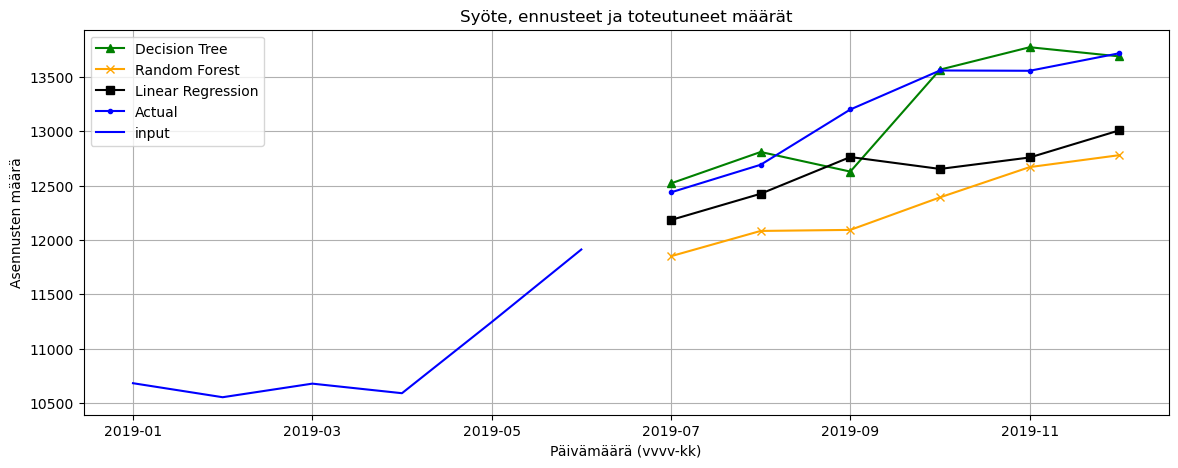

In [11]:
a = input_len
b = input_len + output_len
N = len(seq_df)

def format_date_2(x1, pos=None):
  thisind = np.clip(int(x1 + 0.5), 0, N - 1)
  return x_ticks_range[N - test_size + thisind]

# Piirto
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(np.arange(a, b, 1), dt_seq_preds[0], marker='^', color='green', label='Decision Tree')
ax.plot(np.arange(a, b, 1), rf_seq_preds[0], marker='x', color='orange', label='Random Forest')
ax.plot(np.arange(a, b, 1), lr_seq_preds[0], marker='s', color='black', label='Linear Regression')
ax.plot(np.arange(a, b, 1), y_test[0], marker='.', color='blue', label='Actual')
ax.plot(np.arange(0, a, 1), X_test[0], 'b-', label='input')

locator = mdates.AutoDateLocator(minticks=8, maxticks=12)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(format_date_2)
#fig.autofmt_xdate()
ax.set_xlabel('Päivämäärä (vvvv-kk)')
ax.set_ylabel('Asennusten määrä')
ax.set_title('Syöte, ennusteet ja toteutuneet määrät')
ax.legend()
ax.grid()
plt.show()


Lienee sattumaa, että `Decision Tree` pärjäsi tässä testissä hyvin, kun taas `Random Forest` tekee aivan toisenlaisen skenaarion. Muutamien testien perusteella (jotka eivät näy tässä työkirjassa) `Decision Tree` reagoi voimakkaammin syötteeseen. `Random Forest` tekee ennusteensa ikään kuin maltillisemmin koko opetusaineiston pohjalta.

Alla vielä ennusteiden arvot taulukkona.

In [12]:
res = pd.DataFrame({
  'Actual': y_test[0],
  'Decision Tree': dt_seq_preds[0],
  'Random Forest': rf_seq_preds[0],
  'Linear Regression': lr_seq_preds[0]},
  index=df_ML.index[-output_len:])
display(res)


,Actual,Decision Tree,Random Forest,Linear Regression
2019-07,12438.000000,12520.6,11850.210,12183.561964
2019-08,12692.000000,12809.6,12082.780,12425.044291
2019-09,13200.800000,12629.0,12092.366,12763.017736
2019-10,13559.800000,13567.6,12391.730,12653.471647
2019-11,13557.000000,13773.8,12670.350,12758.865308
2019-12,13718.333333,13689.4,12780.208,13008.486310



## Virheen laskenta

Arvioidaan mallien toimivuuttaa tässä testissä laskemalla ennusteen keskimääräinen virhe (mean absolute percentage error, MAPE).

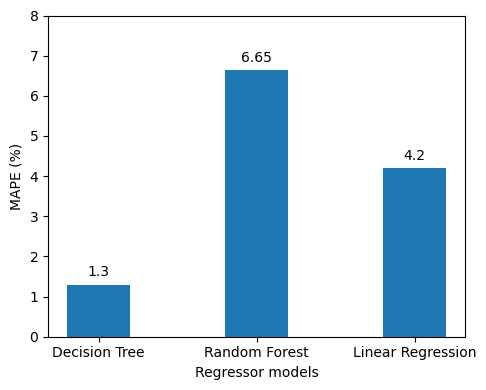

In [13]:
def mape(y_true, y_pred):
  return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)

dt_mape = mape(y_test[0], dt_seq_preds[0])
rf_mape = mape(y_test[0], rf_seq_preds[0])
lr_mape = mape(y_test[0], lr_seq_preds[0])

# Generate bar plot
fig, ax = plt.subplots(figsize=(5, 4))
x = ['Decision Tree', 'Random Forest', 'Linear Regression']
y = [dt_mape, rf_mape, lr_mape]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Regressor models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, int(np.array(y).max() * 1.1 + 1))

for index, value in enumerate(y):
  plt.text(x=index, y=value + 0.2, s=str(value), ha='center')
    
plt.tight_layout()